In [1]:
import kagglehub

path = kagglehub.dataset_download("kenny3s/casia-webface")

print("Path to dataset files:", path)
path=path+"/datasets"

100%|██████████| 1.03G/1.03G [00:17<00:00, 63.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kenny3s/casia-webface/versions/1


In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_images(path):
    images = []
    labels = []
    counter = 0

    for label in os.listdir(path):
        folder_path = os.path.join(path, label)

        # Skip if not a directory
        if not os.path.isdir(folder_path):
            continue

        if len(os.listdir(folder_path)) < 350:
            continue
        else:
            for img in os.listdir(folder_path):
                image_path = os.path.join(folder_path, img)

                # Skip if the file is not an image
                if not os.path.isfile(image_path):
                    continue

                image = cv.imread(image_path)
                if image is None:  # Skip corrupted or unreadable files
                    print(f"Skipping {image_path}, image not loaded.")
                    continue

                image = cv.resize(image, (64, 64))  # Resize all images to a fixed size
                images.append(image)
                labels.append(label)

            counter += 1
            if counter == 51:
                break

    return np.array(images), np.array(labels), counter


In [4]:
image, label,counter= load_images(path)

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [6]:
image=image/255
for i in range(0,2):
  mean=np.mean(image[:,:,:,i])
  std=np.std(image[:,:,:,i])
  image[:,:,:,i]=(image[:,:,:,i]-mean)/std

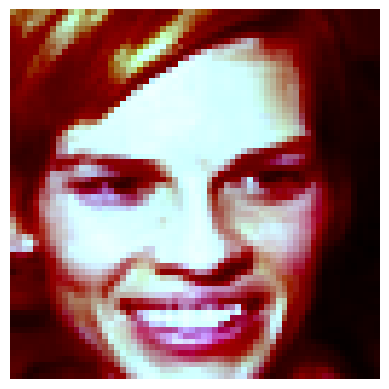

(23487, 64, 64, 3)


In [7]:
plt.imshow(image[105][:,:,::-1])
plt.axis('off')
plt.show()
print(image.shape)

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
encoder = LabelEncoder()


y_encoded = encoder.fit_transform(label)
test_size = 0.15
random_state = 42


image, image_test, y_encoded, y_encoded_test = train_test_split(
    image, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
)

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Reshape, Input
from tensorflow.keras import Model, Sequential

# Function to build encoder
def build_encoder(num_layers, units_per_layer):
    return Sequential([
        Flatten(input_shape=(64, 64, 3))
    ] + [
        Dense(units_per_layer, activation='relu') for _ in range(num_layers)
    ] + [
        Dense(1024, activation='relu')  # Latent space
    ])

# Function to build decoder
def build_decoder(num_layers, units_per_layer):
    return Sequential(
        [Dense(units_per_layer, activation='relu', input_shape=(1024,))] +
        [Dense(units_per_layer, activation='relu') for _ in range(num_layers - 1)] +
        [Dense(64 * 64 * 3, activation='sigmoid'),  # Use Python's arithmetic for the product
         Reshape((64, 64, 3))]  # Reconstruct the original image
    )

# Parameters
input_shape = (64, 64, 3)
num_layers = 3
units_per_layer = 1024

# Layer options
layers_options = [1, 2, 3, 4, 5]

results = []


for i in layers_options:
    # Build encoder and decoder
    encoder = build_encoder(i, 512)
    decoder = build_decoder(i, 512)

    # Define the autoencoder as a single model
    input_layer = Input(shape=input_shape)
    encoded = encoder(input_layer)
    decoded = decoder(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    # Train the model
    history = autoencoder.fit(
        image, image,  # Inputs are also the outputs for autoencoders
        epochs=5,
        batch_size=256,
        validation_split=0.3
    )

    results.append(history)



Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.6717 - loss: 0.5882 - val_accuracy: 0.7841 - val_loss: 0.4578
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7901 - loss: 0.4496 - val_accuracy: 0.8203 - val_loss: 0.4346
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8255 - loss: 0.4300 - val_accuracy: 0.8376 - val_loss: 0.4240
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8394 - loss: 0.4182 - val_accuracy: 0.8460 - val_loss: 0.4177
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8463 - loss: 0.4100 - val_accuracy: 0.8504 - val_loss: 0.4144
Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.6663 - loss: 0.6006 - val_accuracy: 0.7754 - val_loss: 0.4740
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7763 - loss: 0.4626 - val_accuracy: 0.7960 - val_loss: 0.4507
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7992 - loss: 0.4440 - val_accuracy: 0.8201 - val_loss:

'\npredictions = autoencoder.predict(image)\nlatent_representation = encoder.predict(image)\npredictions_test = autoencoder.predict(image_test)\nlatent_representation_test = encoder.predict(image_test)\n'

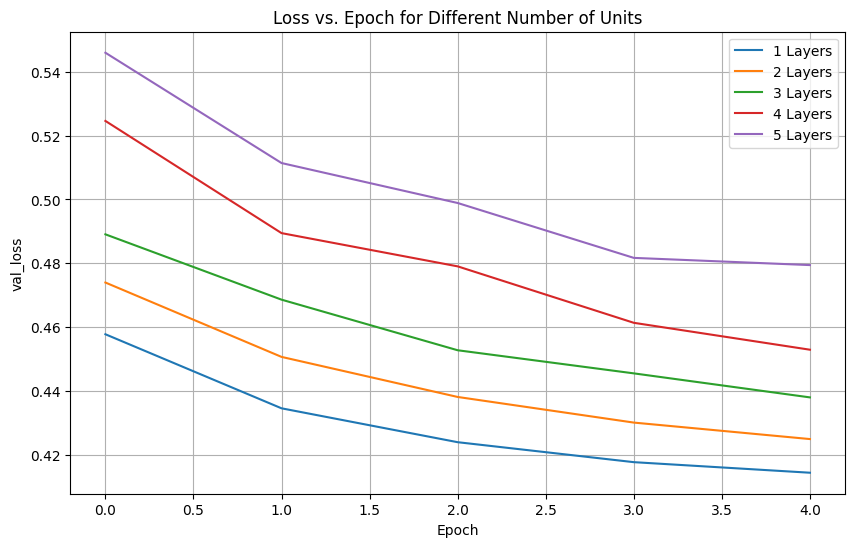

In [26]:
plt.figure(figsize=(10, 6))
for i, history in enumerate(results):
    plt.plot(history.history['val_loss'], label=f'{layers_options[i]} Layers')
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.title('Loss vs. Epoch for Different Number of Units')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
input_shape = (64, 64, 3)
units_options = [64,128,256,512,1024,2048]
results = []
for i in layers_options:
    # Build encoder and decoder
    encoder = build_encoder(1, i)
    decoder = build_decoder(1, i)

    # Define the autoencoder as a single model
    input_layer = Input(shape=input_shape)
    encoded = encoder(input_layer)
    decoded = decoder(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    # Train the model
    history = autoencoder.fit(
        image, image,  # Inputs are also the outputs for autoencoders
        epochs=5,
        batch_size=256,
        validation_split=0.3
    )

    results.append(history)

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.5218 - loss: 0.7989 - val_accuracy: 0.7206 - val_loss: 0.5996
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7181 - loss: 0.5956 - val_accuracy: 0.7260 - val_loss: 0.5927
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7213 - loss: 0.5895 - val_accuracy: 0.7269 - val_loss: 0.5908
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7206 - loss: 0.5899 - val_accuracy: 0.7280 - val_loss: 0.5887
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7222 - loss: 0.5845 - val_accuracy: 0.7295 - val_loss: 0.5869
Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.4902 - loss: 0.7738 - val_accuracy: 0.7213 - val_loss: 0.5970
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7168 - loss: 0.5900 - val_accuracy: 0.7237 - val_loss: 0.5855
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7219 - loss: 0.5856 - val_accuracy: 0.7227 - val_loss:

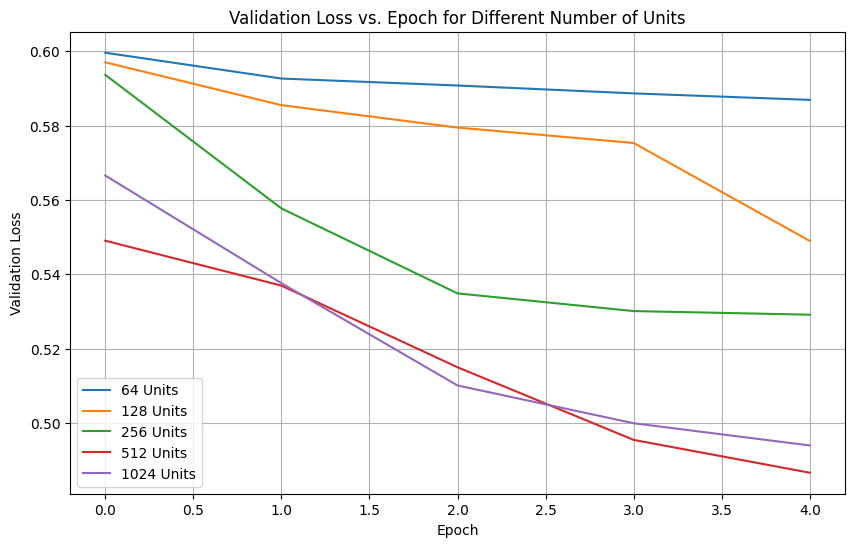

In [24]:
# prompt: loss over number of units

import matplotlib.pyplot as plt

# Assuming 'results' is the list of history objects from your previous code
plt.figure(figsize=(10, 6))
for i, history in enumerate(results):
    plt.plot(history.history['val_loss'], label=f'{units_options[i]} Units') # Use units_options here
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Epoch for Different Number of Units')
plt.legend()
plt.grid(True)
plt.show()